In [23]:
import pandas as pd
from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, accuracy_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pickle
from google.colab import drive
drive.mount('/content/drive')

class Stock_Levels:

  def __init__(self):
    path = "/content/drive/MyDrive/Forage-Cognizant/3. Model Building and Interpretation/"
    self.sales_df = pd.read_csv(f"{path}sales.csv")
    self.sales_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
    self.stock_df = pd.read_csv(f"{path}sensor_stock_levels.csv")
    self.stock_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')
    self.temp_df = pd.read_csv(f"{path}sensor_storage_temperature.csv")
    self.temp_df.drop(columns=["Unnamed: 0"], inplace=True, errors='ignore')

  def convert_to_datetime(self, data: pd.DataFrame = None, column: str = None):
    dummy = data.copy()
    dummy[column] = pd.to_datetime(dummy[column], format='%Y-%m-%d %H:%M:%S')
    return dummy

  def convert_timestamp_to_hourly(self, data: pd.DataFrame = None, column: str = None):
    dummy = data.copy()
    new_ts = dummy[column].tolist()
    new_ts = [i.strftime('%Y-%m-%d %H:00:00') for i in new_ts]
    new_ts = [datetime.strptime(i, '%Y-%m-%d %H:00:00') for i in new_ts]
    dummy[column] = new_ts
    return dummy

  def merge(self):
    self.sales_df = self.convert_to_datetime(self.sales_df, 'timestamp')
    self.stock_df = self.convert_to_datetime(self.stock_df, 'timestamp')
    self.temp_df = self.convert_to_datetime(self.temp_df, 'timestamp')
    self.sales_df = self.convert_timestamp_to_hourly(self.sales_df, 'timestamp')
    self.stock_df = self.convert_timestamp_to_hourly(self.stock_df, 'timestamp')
    self.temp_df = self.convert_timestamp_to_hourly(self.temp_df, 'timestamp')
    self.sales_agg = self.sales_df.groupby(['timestamp', 'product_id']).agg({'quantity': 'sum'}).reset_index()
    self.stock_agg = self.stock_df.groupby(['timestamp', 'product_id']).agg({'estimated_stock_pct': 'mean'}).reset_index()
    self.temp_agg = self.temp_df.groupby(['timestamp']).agg({'temperature': 'mean'}).reset_index()
    self.merged_df = self.stock_agg.merge(self.sales_agg, on=['timestamp', 'product_id'], how='left')
    self.merged_df = self.merged_df.merge(self.temp_agg, on='timestamp', how='left')
    self.merged_df['quantity'] = self.merged_df['quantity'].fillna(0)
    self.product_categories = self.sales_df[['product_id', 'category']]
    self.product_categories = self.product_categories.drop_duplicates()
    self.product_price = self.sales_df[['product_id', 'unit_price']]
    self.product_price = self.product_price.drop_duplicates()
    self.merged_df = self.merged_df.merge(self.product_categories, on="product_id", how="left")
    self.merged_df = self.merged_df.merge(self.product_price, on="product_id", how="left")

  def engineer_feats(self):
    self.merged_df['timestamp_day_of_month'] = self.merged_df['timestamp'].dt.day
    self.merged_df['timestamp_day_of_week'] = self.merged_df['timestamp'].dt.dayofweek
    self.merged_df['timestamp_hour'] = self.merged_df['timestamp'].dt.hour
    self.merged_df.drop(columns=['timestamp'], inplace=True)
    self.merged_df = pd.get_dummies(self.merged_df, columns=['category'])
    self.merged_df.drop(columns=['product_id'], inplace=True)

  def make_model(self):
    X = self.merged_df.drop(columns=['estimated_stock_pct'])
    y = self.merged_df['estimated_stock_pct']
    K = 10
    split = 0.75
    accuracy = []

    for fold in range(0, K):
      model = RandomForestRegressor()
      scaler = StandardScaler()

      X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=split, random_state=42)
      scaler.fit(X_train)
      X_train = scaler.transform(X_train)
      X_test = scaler.transform(X_test)

      trained_model = model.fit(X_train, y_train)
      y_pred = trained_model.predict(X_test)

      mae = mean_absolute_error(y_true=y_test, y_pred=y_pred)
      accuracy.append(mae)
      print(f"Fold {fold + 1}: MAE = {mae:.3f}")

    print(f"Average MAE: {(sum(accuracy) / len(accuracy)):.2f}")
    features = [i.split("__")[0] for i in X.columns]
    importances = model.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots(figsize=(10, 20))
    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()
    return trained_model


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Fold 1: MAE = 0.236
Fold 2: MAE = 0.236
Fold 3: MAE = 0.236
Fold 4: MAE = 0.236
Fold 5: MAE = 0.237
Fold 6: MAE = 0.237
Fold 7: MAE = 0.238
Fold 8: MAE = 0.236
Fold 9: MAE = 0.236
Fold 10: MAE = 0.236
Average MAE: 0.24


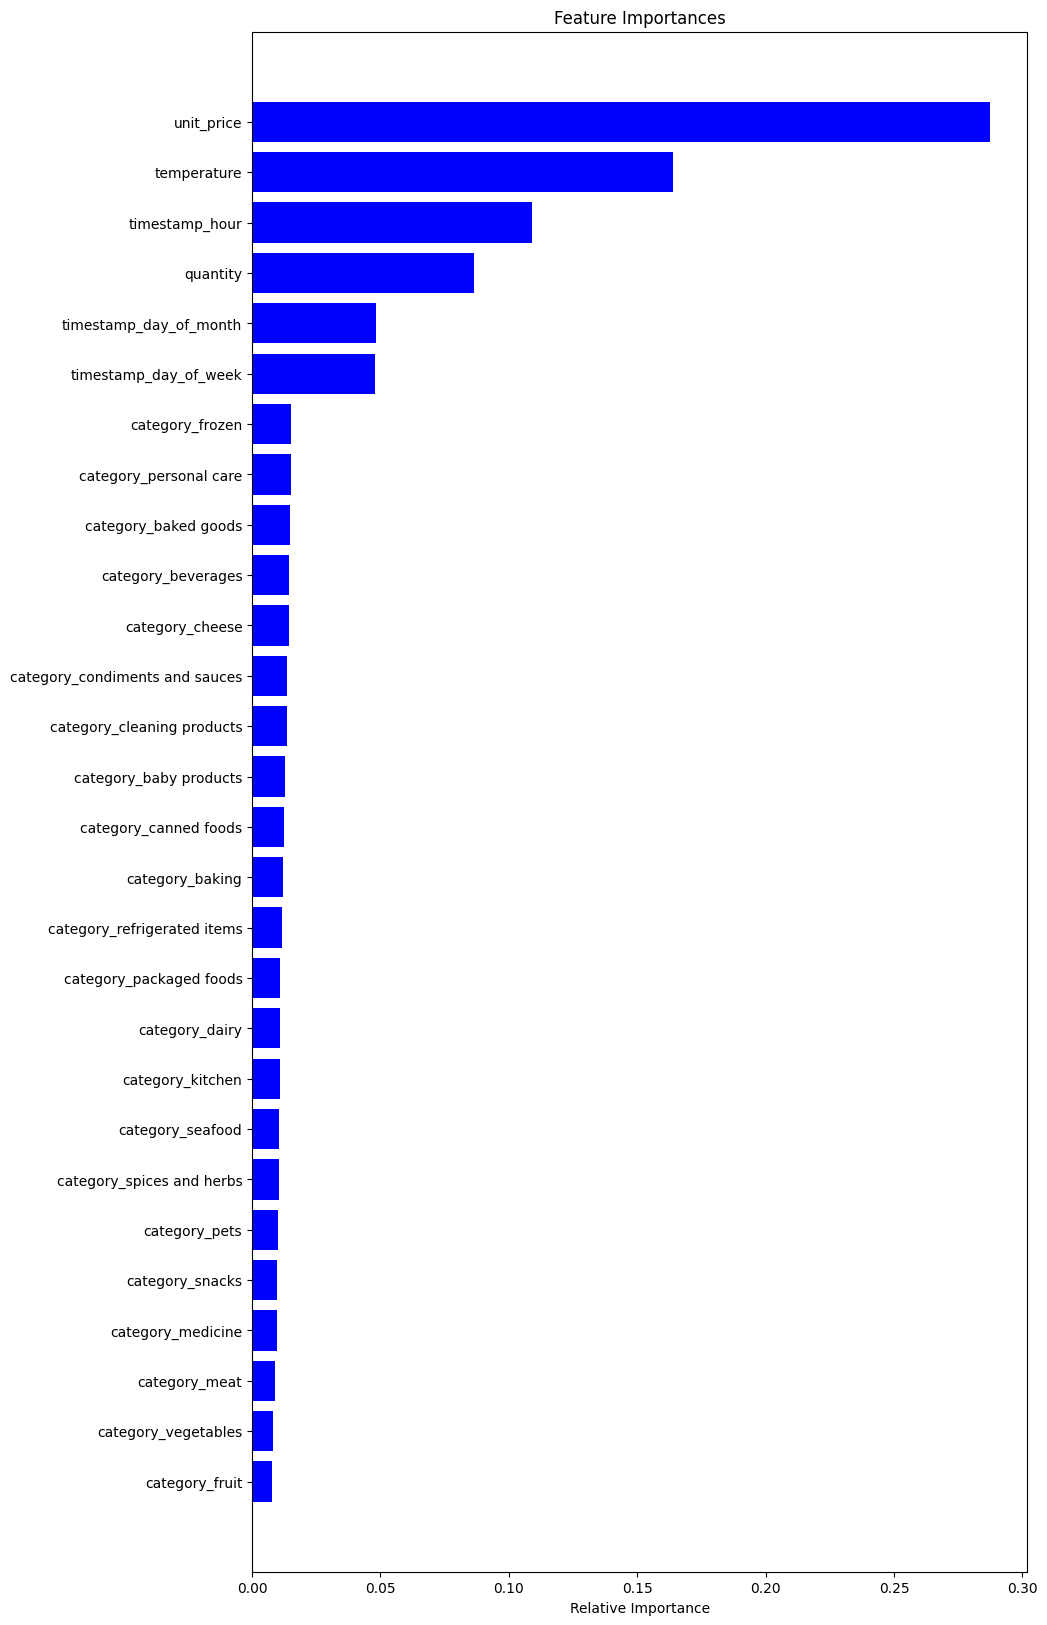

In [24]:
if(__name__=="__main__"):
  ob=Stock_Levels()
  ob.merge()
  ob.engineer_feats()
  model=ob.make_model()
  #This is the trained model that can be pickled and used with suitable data to get estimated stock levels based on important feaures.
  drive.flush_and_unmount()